# The Quantum Fourier Transform

The [Quantum Fourier Transform](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html) is known to provide an exponential speedup in the calculation of Fourier transform when compared to the classical Discrete Fourier Transform and its optimized implementation, the Fast Fourier Transform.

More specifically, the number of gates in the QFT (in its simplest implementation) scales as $O(n^2) = O(\log^2 N)$, where $n$ is the number of qubits and $N=2^n$ is the input size, and similarly does the circuit depth; on the contrary, the runtime of the FFT scales with $O(n2^n)=O(N \log N)$.

Nevertheless, loading data in quantum states with current methods, such as the one implemented in the [Initialize command](https://qiskit.org/documentation/stubs/qiskit.extensions.Initialize.html) of Qiskit, becomes the bottleneck: indeed, in this technique of exact data encoding, the depth scales with $O(N)$; refer to "Synthesis of Quantum Logic Circuits" Shende, Bullock, Markov https://arxiv.org/abs/quant-ph/0406176v5. That is the reason why the QFT is typically used as a building block for other algorithms, rather than as an algorithm on its own.

Anyway applying directly the QFT to a dataset is possible, and the implementation is easy with Qiskit. This notebook demonstrates using Initialize and QFT algorithm to calculate the Quantum Fourier Transform of a sinusoidal signal.

In [1]:
import numpy as np
# Importing standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, execute


In [2]:
import matplotlib.pyplot as plt

## Generation of data

We define a function that generates a uniform sampling of a given domain `[x_lim[0], x_lim[1]]` in $2^n$ samples, and evaluates a $2\pi \lambda$-periodic sinuisoidal signal in such points:

In [3]:
def gen_data(num_qubits, x_lim, lam):
    num_samples = 2**num_qubits
    x = np.arange(x_lim[0], x_lim[1], (x_lim[1]-x_lim[0])/num_samples)
    y = np.sin(lam * 2*np.pi * x)
    return x, y

In [4]:
num_qubits = 7
x_lim = [0, 2**3]
lam = 2

x, y = gen_data(num_qubits, x_lim, lam)

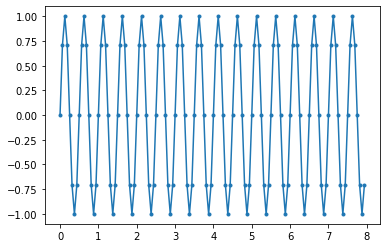

In [5]:
plt.plot(x, y, '.-')

## The classical case

At first, we use the classical FFT.

In [6]:
xhat = np.arange(0, 2**num_qubits/(x_lim[1]-x_lim[0]), 1/(x_lim[1]-x_lim[0]))

yhat = np.fft.fft(y)/len(y)

We can narrow our look on the first half of Fourier coefficients, and observe that the DFT clearly shows our period $2\pi \lambda$ with $\lambda = 2$:

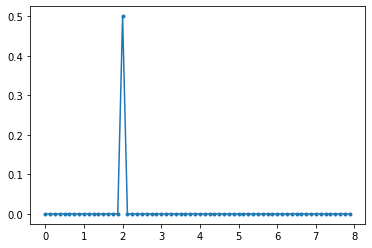

In [7]:
xhat_half = xhat[range(len(x)//2)]
yhat_half = yhat[range(len(yhat)//2)]
plt.plot(xhat_half, abs(yhat_half), '.-')

## The quantum case

Let's now move to the quantum version.

We want to encode data $\left\{f_x\right\}_{x=0}^{N-1}$ in the amplitudes, i.e. in the form $\sum_{x=0}^{N-1} f_x |x\rangle$, so that by linearity, the QFT maps:
$$\sum_{x=0}^{N-1} f_x |x\rangle \mapsto \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{k=0}^{N-1} f_x \omega_N^{xk} |k\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \tilde{f}_k |k\rangle, $$
where we obtained $\left\{\tilde{f}_k\right\}_{k=0}^{N-1}$ that is by definition the result of the Fourier transformation.

In order to apply the data encoding, then, we need to rescale the input so that the vector is normalized.

We define a function that builds the circuit for input normalization, data encoding and QFT application.

In [8]:
def generate_circuit(y):
    y_normal = y / np.linalg.norm(y)
    num_qubits = int(np.log2(len(y_normal)))
    
    qc = QuantumCircuit(num_qubits)
    init = qiskit.extensions.Initialize(y_normal)
    qc.append(init, [i for i in range(num_qubits)])
    
    qft = qiskit.circuit.library.QFT(num_qubits)
    qc.append(qft, [i for i in range(num_qubits)])
    
    return qc, init, qft

In [9]:
qc, init, qft = generate_circuit(y)

In [10]:
prob = execute(qc, backend = Aer.get_backend('statevector_simulator')).result().get_counts()

In [11]:
yhat_quantum = np.zeros(len(y))
for key in prob:
    yhat_quantum[int(key, 2)] = np.sqrt(prob[key])

The QFT behaves exactly as the DFT, discarding a rescaling factor due to the different normalization of the input data, and the different definitions of QFT vs DFT:

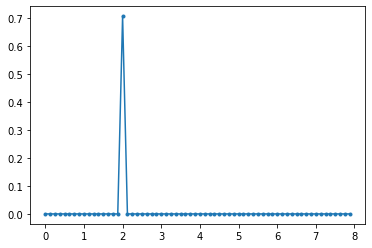

In [12]:
yhat_quantum_half = yhat_quantum[range(len(yhat_quantum)//2)]
plt.plot(xhat_half, yhat_quantum_half, '.-')

Let's now look at the circuit depth:

In [ ]:
array_depth_init = []
array_depth_qft = []

for num_qubits in range(1,10):
    x, y = gen_data(num_qubits, x_lim, lam)
    qc, init, qft = generate_circuit(y)
    
    depth_init = transpile(init.gates_to_uncompute(), basis_gates=['u3','cx']).depth()
    array_depth_init.append(depth_init)
    
    depth_qft = transpile(qft, basis_gates=['u3','cx']).depth()
    array_depth_qft.append(depth_qft)
    
    print(f'num_qubits: {num_qubits}, depth_init: {depth_init}, depth_qft: {depth_qft}')

num_qubits: 1, depth_init: 1, depth_qft: 1
num_qubits: 2, depth_init: 5, depth_qft: 8
num_qubits: 3, depth_init: 17, depth_qft: 16
num_qubits: 4, depth_init: 39, depth_qft: 24
num_qubits: 5, depth_init: 105, depth_qft: 32
num_qubits: 6, depth_init: 212, depth_qft: 40
num_qubits: 7, depth_init: 478, depth_qft: 48
num_qubits: 8, depth_init: 984, depth_qft: 56


As we know from the theory, the QFT scales logarithmically, but the loading part scales linearly:

In [ ]:
plt.plot([2**num_qubits for num_qubits in range(1,10)], array_depth_qft, '.-', color='green', label='qft')
plt.legend(loc='best')
plt.xlabel('input size')
plt.ylabel('depth')
plt.show()

In [ ]:
plt.plot([2**num_qubits for num_qubits in range(1,10)], array_depth_init, '.-', color='violet', label='init')
plt.plot([2**num_qubits for num_qubits in range(1,10)], array_depth_qft, '.-', color='green', label='qft')
plt.legend(loc='best')
plt.xlabel('input size')
plt.ylabel('depth')
plt.show()

Same plots as before, where the input size is in log scale:

In [ ]:
plt.plot(range(1,10), array_depth_qft, '.-', color='green', label='qft')
plt.legend(loc='best')
plt.xlabel('num_qubits')
plt.ylabel('depth')
plt.show()

In [ ]:
plt.plot(range(1,10), array_depth_init, '.-', color='violet', label='init')
plt.plot(range(1,10), array_depth_qft, '.-', color='green', label='qft')
plt.legend(loc='best')
plt.xlabel('num_qubits')
plt.ylabel('depth')
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright